In [80]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
from sklearn.metrics import confusion_matrix


In [81]:
DATA_PATH = "/kaggle/input/drive-digital-retinal-images-for-vessel-extraction/DRIVE"

IMAGE_PATH = os.path.join(DATA_PATH, "training/images")
GT_PATH = os.path.join(DATA_PATH, "training/1st_manual")
FOV_PATH = os.path.join(DATA_PATH, "training/mask")

image_files = sorted(os.listdir(IMAGE_PATH))
gt_files = sorted(os.listdir(GT_PATH))
fov_files = sorted(os.listdir(FOV_PATH))

print("Total Images:", len(image_files))


Total Images: 20


In [82]:
def preprocess(path):
    img = cv2.imread(path)
    green = img[:, :, 1]  
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(green)
    
    return enhanced


In [83]:
def extract_thin(mask):
    mask = mask // 255
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(mask, kernel, iterations=1)
    thin = mask - eroded
    thin[thin < 0] = 0
    return thin


In [84]:
def niblack_threshold(image):
    
    thresh = threshold_niblack(image, window_size=35, k=-0.1)
    binary = (image < thresh).astype(np.uint8)
    
    # remove small noise
    kernel = np.ones((2,2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    return binary


In [85]:
def sauvola_threshold(image):
    
    thresh = threshold_sauvola(image, window_size=45, k=0.1)
    binary = (image < thresh).astype(np.uint8)
    
    # remove small noise
    kernel = np.ones((2,2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    return binary


In [86]:
def compute_metrics(gt, pred, fov):
    
    valid = (fov // 255).flatten() == 1
    
    gt = gt.flatten()[valid].astype(int)
    pred = pred.flatten()[valid].astype(int)
    
    cm = confusion_matrix(gt, pred, labels=[0,1])
    
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    tp = cm[1,1]
    
    sensitivity = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)
    
    return sensitivity, specificity, accuracy, dice


In [87]:
niblack_results = []
sauvola_results = []

for i in range(len(image_files)):
    
    img = preprocess(os.path.join(IMAGE_PATH, image_files[i]))
    gt = cv2.imread(os.path.join(GT_PATH, gt_files[i]), 0)
    fov = cv2.imread(os.path.join(FOV_PATH, fov_files[i]), 0)
    
    thin_gt = extract_thin(gt)
    
    n_pred = niblack_threshold(img)
    s_pred = sauvola_threshold(img)
    
    niblack_results.append(compute_metrics(thin_gt, n_pred, fov))
    sauvola_results.append(compute_metrics(thin_gt, s_pred, fov))

niblack_results = np.array(niblack_results)
sauvola_results = np.array(sauvola_results)


In [88]:
print("\n FINAL AVERAGE METRICS ")

print("\nNIBLACK")
print("Sensitivity:", np.mean(niblack_results[:,0]))
print("Specificity:", np.mean(niblack_results[:,1]))
print("Accuracy:", np.mean(niblack_results[:,2]))
print("Dice:", np.mean(niblack_results[:,3]))

print("\nSAUVOLA")
print("Sensitivity:", np.mean(sauvola_results[:,0]))
print("Specificity:", np.mean(sauvola_results[:,1]))
print("Accuracy:", np.mean(sauvola_results[:,2]))
print("Dice:", np.mean(sauvola_results[:,3]))



 FINAL AVERAGE METRICS 

NIBLACK
Sensitivity: 0.6980358380934528
Specificity: 0.6490820063860097
Accuracy: 0.6527034215329721
Dice: 0.2443485306512118

SAUVOLA
Sensitivity: 0.45931277727072883
Specificity: 0.8798401246184646
Accuracy: 0.8457408455038793
Dice: 0.3248676958046212


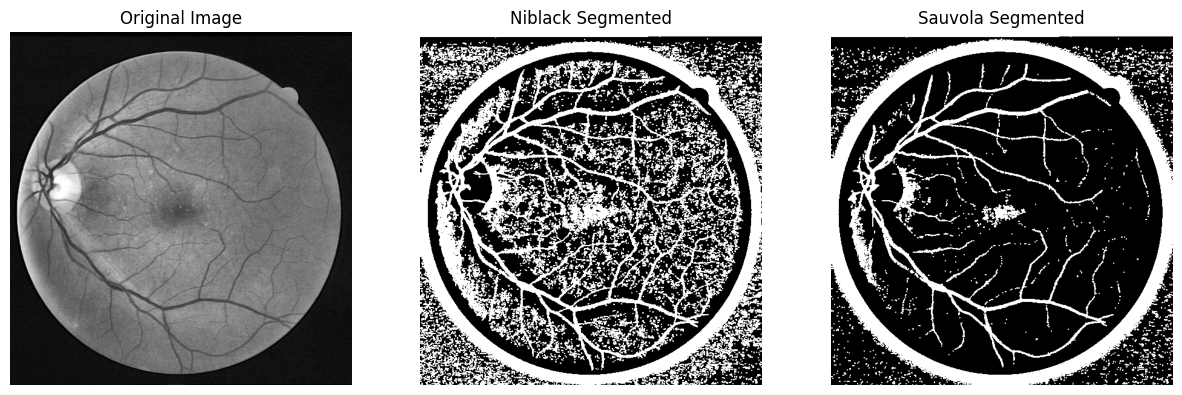

In [89]:
index = 0

img = preprocess(os.path.join(IMAGE_PATH, image_files[index]))

n_pred = niblack_threshold(img)
s_pred = sauvola_threshold(img)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Niblack Segmented")
plt.imshow(n_pred, cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Sauvola Segmented")
plt.imshow(s_pred, cmap='gray')
plt.axis("off")

plt.show()


**Result and Discussion**

Thin retinal vessels were extracted using Niblack and Sauvola adaptive thresholding on the DRIVE dataset. Niblack achieved higher sensitivity (0.69), meaning it detected more thin vessels, but it also produced significant noise, resulting in lower Dice score (0.24) and moderate specificity (0.65).

Sauvola showed lower sensitivity (0.46) but much higher specificity (0.88) and better Dice score (0.32), indicating cleaner and more accurate segmentation.

Overall, Niblack is more aggressive in detecting thin vessels, while Sauvola provides better overall segmentation quality by reducing false positives.